In [1]:
import csv
from scipy import sparse
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
base_path = '/bigstore/binfo/mouse/Brain/Sequencing/Allen_10X_SmartSeqTypes/'
genes = list(pd.read_csv(os.path.join(base_path,'dredfish_filtered_genes.csv'),index_col=0,header=None).index)
cells = list(pd.read_csv(os.path.join(base_path,'sorted_cells.csv'),index_col=0,header=None).index)
metadata = pd.read_csv(os.path.join(base_path,'sorted_metadata.csv'),index_col=0).loc[cells]
labels = list(metadata['cell_type_alias_label'])
counts = np.load(os.path.join(base_path,'dredfish_normcounts.npy'))

/home/zach/miniconda3/envs/pyspots-gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (54) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [22]:
[i for i in np.unique(list(metadata['cell_type_alias_label'])) if not i=='nan']

['100_Sst',
 '101_Sst',
 '102_Sst',
 '103_Sst',
 '104_Sst',
 '105_Pvalb',
 '106_Pvalb',
 '107_Pvalb',
 '108_Pvalb',
 '109_Pvalb',
 '10_Lamp5',
 '110_Pvalb',
 '111_Pvalb',
 '112_Pvalb',
 '113_Pvalb',
 '114_Pvalb',
 '115_Pvalb',
 '116_Pvalb',
 '117_Pvalb',
 '118_Pvalb',
 '119_Pvalb Vipr2',
 '11_Lamp5',
 '120_DG',
 '121_DG',
 '122_DG',
 '123_DG',
 '124_DG',
 '125_DG',
 '126_L2/3 IT APr',
 '127_L2/3 IT APr',
 '128_L2/3 IT APr',
 '129_L2/3 IT APr',
 '12_Lamp5',
 '130_L2 IT RSPv',
 '131_L2 IT RSPv',
 '132_L2/3 IT PPP',
 '133_L2/3 IT PPP',
 '134_L2/3 IT PPP',
 '135_L2/3 IT PPP',
 '136_L2/3 IT PPP',
 '137_L2 IT ENTl',
 '138_L2 IT ENTl',
 '139_L2 IT ENTl',
 '13_Lamp5',
 '140_L3 IT ENTm',
 '141_L3 IT ENTm',
 '142_L3 IT ENTm',
 '143_L3 IT ENTm',
 '144_L3 IT ENTl',
 '145_L3 IT ENTl',
 '146_L3 IT ENTl',
 '147_L2 IT PAR',
 '148_L2 IT PAR',
 '149_L2 IT PAR',
 '14_Lamp5',
 '150_L2 IT ENTm',
 '151_L2 IT ENTm',
 '152_L2 IT ENTm',
 '153_L2 IT ENTm',
 '154_L2 IT ProS',
 '155_L2 IT ProS',
 '156_L2 IT ProS'

In [23]:
# Class Balance
unqtypes = [i for i in np.unique(list(metadata['cell_type_alias_label'])) if not i=='nan']
n = 100
class_balanced = np.empty((len(unqtypes)*n,len(genes)))
balanced_labels = np.empty((len(unqtypes)*n)).astype(str)
for i,ct in tqdm(enumerate(unqtypes),total=len(unqtypes)):
    start = i*n
    end = (i+1)*n
    ct_indexes = np.where(np.array(labels)==ct)[0]
    if len(ct_indexes)>n:
        ct_indexes = np.random.choice(ct_indexes,n,replace=False)
    else:
        ct_indexes = np.random.choice(ct_indexes,n,replace=True)
    balanced_labels[start:end] = ct
    class_balanced[start:end,:] = counts[ct_indexes,:]
del counts

  0%|          | 0/373 [00:00<?, ?it/s]


NameError: name 'counts' is not defined

In [3]:
# Dimensional Reduce
from sklearn.decomposition import PCA
nbits = 12
pca = PCA(n_components=nbits)
pca_out = pca.fit(class_balanced)
nonpositive_loadings = pca_out.components_.T
loadings = np.empty((len(genes),2*nbits))
loadings[:,0:nbits] = nonpositive_loadings
loadings[:,nbits:2*nbits] = -nonpositive_loadings
loadings[loadings<0] = 0
nprobes = 70
probes = (nprobes*loadings/np.max(loadings,axis=0)[:,None].T).astype('uint16')
compressed = np.matmul(class_balanced,probes).astype('uint16')
compressed.shape

(37400, 24)

In [171]:
# # Great place to do R
# """
# https://rpy2.github.io/doc/v2.9.x/html/introduction.html
# """
# import rpy2
# import rpy2.robjects as robjects
# from rpy2.robjects.packages import importr
# base = importr('base')
# utils = importr('utils')
# pnmfs = importr('QuickPNMFs')
# import rpy2.robjects.numpy2ri
# rpy2.robjects.numpy2ri.activate()
# r_class_balanced = robjects.r.matrix(class_balanced.T)
# r_balanced_labels = robjects.r.matrix(balanced_labels)

In [178]:
# pnmf_out = pnmfs.PNMFfun(r_class_balanced, rank=18,method="DPNMF", label=r_balanced_labels)

R[write to console]: Error in irlba(X, nv = rank) : 
  max(nu, nv) must be strictly less than min(nrow(A), ncol(A))

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages

R[write to console]: 3: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages



RRuntimeError: Error in irlba(X, nv = rank) : 
  max(nu, nv) must be strictly less than min(nrow(A), ncol(A))


In [38]:
# loadings = np.load(os.path.join(base_path,'dpnmf_loadings.npy'))
# nprobes = 70
# probes = (nprobes*loadings/np.max(loadings,axis=1)[:,None]).astype('uint16')
# compressed = np.matmul(counts,probes.T).astype('uint16')

93285

In [4]:
from scipy.stats import multivariate_normal
def NBClassify(ref,test,labels):
    unqtypes = np.unique(labels)
    likelihood = np.nan*np.zeros((len(labels),len(unqtypes)))
    for i,ct in tqdm(enumerate(unqtypes),total=len(unqtypes)):
        ct_indexes = np.where(np.array(labels)==ct)[0]
        ct_ref = ref[ct_indexes,:]
        ct_means = np.mean(ct_ref,axis=0)
        ct_cov = np.cov(ct_ref.T)
        try:
            likelihood[:,i] = multivariate_normal.pdf(test,mean=ct_means, cov=ct_cov)
        except:
            print(ct,' Is Singular Matrix',len(ct_indexes))
            continue
    return likelihood
labels = balanced_labels.copy()#list(metadata['cell_type_alias_label'])
likelihood = NBClassify(compressed,compressed,labels)
labels = balanced_labels.copy()#np.array(list(metadata['cell_type_alias_label']))
unqtypes = np.unique(labels)
prior = np.array([len(labels[(np.array(labels)==ct)])/len(labels) for ct in np.unique(labels)])
log_prior = np.log10(prior)
log_likelihood = np.log10(likelihood)
log_likelihood = np.nan_to_num(log_likelihood,nan=-np.inf)
posterior = log_likelihood+log_prior
posterior[posterior==np.nan]= -np.inf
predicted_idx = np.argmax(posterior,axis=1)
predicted_ct = unqtypes[predicted_idx]

 83%|████████▎ | 310/374 [00:10<00:01, 33.27it/s]

376_VLMC  Is Singular Matrix 100


100%|██████████| 374/374 [00:12<00:00, 29.51it/s]


97_Sst  Is Singular Matrix 100


/home/zach/miniconda3/envs/pyspots-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


In [ ]:
"""
Some types have few cells and result in a singluar matrix
Values returned are much higher than other cell types
Should I dismiss them
"""

In [9]:
from collections import Counter
Counter(predicted_ct)

Counter({'372_SMC': 238,
         '39_Lamp5': 83,
         '184_L2/3 IT TPE': 90,
         '90_Sst': 115,
         '25_Sncg': 99,
         '181_L2/3 IT CTX': 109,
         '155_L2 IT ProS': 65,
         '332_L6 CT ENTm': 87,
         '244_L5 PT CTX': 115,
         '326_L6 CT CTX': 85,
         '318_CT SUB': 91,
         '377_Micro': 78,
         '205_L5 IT CTX': 105,
         '100_Sst': 93,
         '211_L5 IT TPE-ENT': 75,
         '369_Endo': 186,
         '194_L4/5 IT CTX': 87,
         '26_Sncg': 87,
         '60_Sst Chodl': 112,
         '283_CA1': 109,
         '68_Sst': 64,
         '323_L6 CT CTX': 97,
         '45_Vip': 58,
         '289_CA1': 93,
         '178_L2/3 IT CTX': 85,
         '192_L4/5 IT CTX': 110,
         '313_NP SUB': 98,
         '44_Vip': 75,
         '65_Sst': 77,
         '120_DG': 103,
         '360_OPC': 90,
         '319_CT SUB': 80,
         '352_NP PPP': 117,
         '282_CA1': 200,
         '235_L3 RSP-ACA': 100,
         '301_CA2-IG-FC': 82,
       

In [10]:
len([i for i in range(len(labels)) if labels[i]==predicted_ct[i]])/len(labels)

0.18516042780748662

In [12]:
# Load Dendrogram
def find_next_nodes(node):
    if 'leaf_attributes' in node.keys():
        A = None
        B = None
        C = node['leaf_attributes'][0]['original_label']
        H = node['leaf_attributes'][0]['height']
        Children = []
    elif 'node_attributes' in node.keys():
        try:
            A = node['children'][0]['node_attributes'][0]['original_label']
        except:
            A = node['children'][0]['leaf_attributes'][0]['original_label']
        try:
            B = node['children'][1]['node_attributes'][0]['original_label']
        except:
            B = node['children'][1]['leaf_attributes'][0]['original_label']
        C = node['node_attributes'][0]['original_label']
        H = node['node_attributes'][0]['height']
        Children = node['children']
    return A,B,C,H,Children
def dend2linkage(dend):
    A_list = []
    B_list = []
    C_list = []
    H_list = []
    Children_list = []
    A,B,C,H,Children = find_next_nodes(dend)
    A_list.append(A)
    B_list.append(B)
    C_list.append(C)
    H_list.append(H)
    Children_list.extend(Children)
    while len(Children_list)>0:
        new_Children_list = []
        for child in Children_list:
            A,B,C,H,Children = find_next_nodes(child)
            A_list.append(A)
            B_list.append(B)
            C_list.append(C)
            H_list.append(H)
            new_Children_list.extend(Children)
        Children_list = new_Children_list
    linkage = pd.DataFrame()
    linkage['A'] = A_list
    linkage['B'] = B_list
    linkage['C'] = C_list
    linkage['H'] = H_list
    linkage = linkage.sort_values('H')
    return linkage

import json
with open(os.path.join(base_path,'dend.json')) as f:
    dend = json.load(f)
linkage = dend2linkage(dend)

In [13]:
# Load Dendrogram
def find_next_nodes(node):
    if 'leaf_attributes' in node.keys():
        A = None
        B = None
        C = node['leaf_attributes'][0]['original_label']
        H = node['leaf_attributes'][0]['height']
        Children = []
    elif 'node_attributes' in node.keys():
        try:
            A = node['children'][0]['node_attributes'][0]['original_label']
        except:
            A = node['children'][0]['leaf_attributes'][0]['original_label']
        try:
            B = node['children'][1]['node_attributes'][0]['original_label']
        except:
            B = node['children'][1]['leaf_attributes'][0]['original_label']
        C = node['node_attributes'][0]['original_label']
        H = node['node_attributes'][0]['height']
        Children = node['children']
    return A,B,C,H,Children
def dend2linkage(dend):
    A_list = []
    B_list = []
    C_list = []
    H_list = []
    Children_list = []
    A,B,C,H,Children = find_next_nodes(dend)
    A_list.append(A)
    B_list.append(B)
    C_list.append(C)
    H_list.append(H)
    Children_list.extend(Children)
    while len(Children_list)>0:
        new_Children_list = []
        for child in Children_list:
            A,B,C,H,Children = find_next_nodes(child)
            A_list.append(A)
            B_list.append(B)
            C_list.append(C)
            H_list.append(H)
            new_Children_list.extend(Children)
        Children_list = new_Children_list
    linkage = pd.DataFrame()
    linkage['A'] = A_list
    linkage['B'] = B_list
    linkage['C'] = C_list
    linkage['H'] = H_list
    linkage = linkage.sort_values('H')
    return linkage

import json
with open(os.path.join(base_path,'dend.json')) as f:
    dend = json.load(f)
linkage = dend2linkage(dend)def calc_ROC(level_true,level_predicted,linkage):
    level_true = level_true.copy()
    level_predicted = level_predicted.copy()
    H = linkage['H'].unique()
    ROC = np.empty(len(H))
    accurate = np.zeros(len(level_true))
    for i,h in enumerate(H):
        not_accurate = np.where(accurate==0)[0]
        accurate[[i for i in not_accurate if level_true[i]==level_predicted[i]]] = 1
        ROC[i] = np.sum(accurate)/len(level_true)
        temp_linkage = linkage[linkage['H']==h]
        for idx,row in temp_linkage.iterrows():
            next_level = row['C']
            a = row['A']
            if not isinstance(a,type(None)):
                level_true[level_true==a] = next_level
                level_predicted[level_predicted==a] = next_level
            b = row['B']
            if not isinstance(b,type(None)):
                level_true[level_true==b] = next_level
                level_predicted[level_predicted==b] = next_level
    return H,ROC
labels = balanced_labels.copy()#list(metadata['cell_type_alias_label'])
H,ROC = calc_ROC(labels.copy(),predicted_ct.copy(),linkage)

In [14]:
import random
permuted = balanced_labels.copy()#list(metadata['cell_type_alias_label'])
random.shuffle(permuted)
RH,RROC = calc_ROC(labels.copy(),permuted.copy(),linkage)

In [16]:
RROC

array([0.00286096, 0.00286096, 0.00286096, 0.00286096, 0.00286096,
       0.00286096, 0.00286096, 0.00286096, 0.00286096, 0.00286096,
       0.0028877 , 0.00294118, 0.00294118, 0.00294118, 0.00294118,
       0.00294118, 0.00294118, 0.00294118, 0.00299465, 0.00299465,
       0.00299465, 0.0031016 , 0.0031016 , 0.00312834, 0.00315508,
       0.00318182, 0.00320856, 0.00320856, 0.00320856, 0.00320856,
       0.00320856, 0.00323529, 0.00323529, 0.00326203, 0.00334225,
       0.00336898, 0.00339572, 0.00339572, 0.00339572, 0.00339572,
       0.00339572, 0.00339572, 0.00339572, 0.00347594, 0.00352941,
       0.00355615, 0.00358289, 0.00358289, 0.00360963, 0.00360963,
       0.00363636, 0.00363636, 0.00379679, 0.00385027, 0.00385027,
       0.00395722, 0.00395722, 0.00406417, 0.00409091, 0.00417112,
       0.00417112, 0.00430481, 0.00433155, 0.0044385 , 0.0044385 ,
       0.00449198, 0.00454545, 0.00454545, 0.00454545, 0.00459893,
       0.00459893, 0.00462567, 0.00465241, 0.00467914, 0.00473

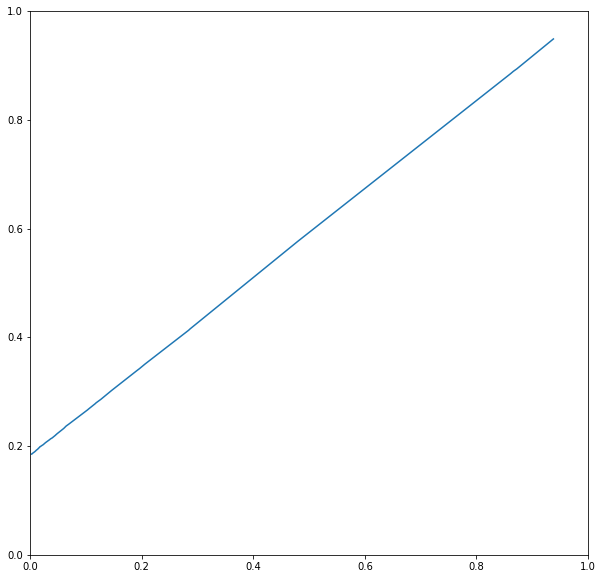

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10,10])
plt.plot(RROC,ROC)
plt.ylim([0,1])
plt.xlim([0,1])
plt.show()

In [ ]:
# Reduce the number of genes down to 5000 